In [1]:
import os
import pathlib
import sys

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
import tifffile
from matplotlib.colors import BoundaryNorm, ListedColormap
from skimage import io

cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd
else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break
sys.path.append(str(root_dir / "utils"))
from arg_parsing_utils import check_for_missing_args, parse_args
from file_reading import read_zstack_image
from notebook_init_utils import bandicoot_check, init_notebook

root_dir, in_notebook = init_notebook()

if in_notebook:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [ ]:
def convert_indexed_mask_to_binary_mask(indexed_mask: np.ndarray) -> np.ndarray:
    """
    Convert an indexed mask to a binary mask.

    Parameters
    ----------
    indexed_mask : np.ndarray
        An indexed mask where 0 represents the background and any positive integer represents a different object.

    Returns
    -------
    np.ndarray
        A binary mask where True represents the foreground (objects) and False represents the background.
    """
    binary_mask = np.zeros_like(indexed_mask, dtype=bool)
    binary_mask[indexed_mask > 0] = True
    return binary_mask


def extract_IOU(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """
    Calculate the Intersection over Union (IoU) between two binary masks.

    Parameters
    ----------
    mask1 : np.ndarray
        A binary mask where True represents the foreground (objects) and False represents the background.
    mask2 : np.ndarray
        A binary mask where True represents the foreground (objects) and False represents the background.

    Returns
    -------
    float
        The Intersection over Union (IoU) score between the two masks.
    """
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / (np.sum(union) + 1e-12)
    return iou_score.item()


def signed_xor_3color(mask1, mask2):
    """
    Create a 3-value difference map:
    - 2 where only mask1 is True (decon only)
    - 1 where only mask2 is True (other only)
    - 0 where both masks agree
    """
    result = np.zeros_like(mask1, dtype=int)
    result[mask1 & ~mask2] = 2  # decon only
    result[~mask1 & mask2] = 1  # other only
    return result

In [3]:
if not in_notebook:
    args = parse_args()
    window_size = args["window_size"]
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        window_size=window_size,
        clip_limit=clip_limit,
    )
else:
    print("Running in a notebook")
    patient = "NF0014_T1"
    well_fov = "C4-2"
    window_size = 3
    clip_limit = 0.05


list_of_dirs = []

input_dir_raw = pathlib.Path(
    f"{image_base_dir}/data/{patient}/zstack_images/{well_fov}"
).resolve(strict=True)
input_dir_decon = pathlib.Path(
    f"{image_base_dir}/data/{patient}/deconvolved_images/{well_fov}"
).resolve(strict=True)
list_of_dirs.append(input_dir_raw)
list_of_dirs.append(input_dir_decon)
for i in range(25):
    list_of_dirs.append(
        pathlib.Path(
            f"{image_base_dir}/data/{patient}/convolution_{i + 1}/{well_fov}"
        ).resolve(strict=True)
    )
for i in [25, 50, 75, 100]:
    output_dir = pathlib.Path(
        f"{image_base_dir}/data/{patient}/convolution_{i}/{well_fov}"
    ).resolve()
    output_dir.mkdir(parents=True, exist_ok=True)
    list_of_dirs.append(output_dir)

Running in a notebook


In [4]:
# get the segmentation masks
masks_dict = {
    "data_set": [],
    "image_path": [],
}
for dir_path in list_of_dirs:
    mask_files = sorted(dir_path.glob("*.tiff"))
    mask_files = [x for x in mask_files if "mask" in x.stem]
    for mask_file in mask_files:
        masks_dict["data_set"].append(str(dir_path).split("/")[-2])
        masks_dict["image_path"].append(mask_file)

In [5]:
# anchor the decon as the comparator
dict_of_compartments = {
    "organoid": {
        "decon": [],
        "all_other_masks": [],
        "all_other_labels": [],
    },
    "nuclei": {
        "decon": [],
        "all_other_masks": [],
        "all_other_labels": [],
    },
    "cell": {
        "decon": [],
        "all_other_masks": [],
        "all_other_labels": [],
    },
    "cytoplasm": {
        "decon": [],
        "all_other_masks": [],
        "all_other_labels": [],
    },
}

In [6]:
for i, key in enumerate(masks_dict["data_set"]):
    if "organoid" in str(masks_dict["image_path"][i].stem):
        if "decon" in str(masks_dict["image_path"][i]):
            dict_of_compartments["organoid"]["decon"].append(
                masks_dict["image_path"][i]
            )
        else:
            dict_of_compartments["organoid"]["all_other_masks"].append(
                masks_dict["image_path"][i]
            )
            dict_of_compartments["organoid"]["all_other_labels"].append(key)
    elif "nuclei" in str(masks_dict["image_path"][i].stem):
        if "decon" in str(masks_dict["image_path"][i]):
            dict_of_compartments["nuclei"]["decon"].append(masks_dict["image_path"][i])
        else:
            dict_of_compartments["nuclei"]["all_other_masks"].append(
                masks_dict["image_path"][i]
            )
            dict_of_compartments["nuclei"]["all_other_labels"].append(key)
    elif "cell" in str(masks_dict["image_path"][i].stem):
        if "decon" in str(masks_dict["image_path"][i]):
            dict_of_compartments["cell"]["decon"].append(masks_dict["image_path"][i])
        else:
            dict_of_compartments["cell"]["all_other_masks"].append(
                masks_dict["image_path"][i]
            )
            dict_of_compartments["cell"]["all_other_labels"].append(key)
    elif "cytoplasm" in str(masks_dict["image_path"][i].stem):
        if "decon" in str(masks_dict["image_path"][i]):
            dict_of_compartments["cytoplasm"]["decon"].append(
                masks_dict["image_path"][i]
            )
        else:
            dict_of_compartments["cytoplasm"]["all_other_masks"].append(
                masks_dict["image_path"][i]
            )
            dict_of_compartments["cytoplasm"]["all_other_labels"].append(key)

In [7]:
IOU_scores = {}
# loop through all compartments and calculate IOU scores
# for each convolution mask against the decon mask
for compartment in tqdm(
    dict_of_compartments.keys(),
    desc="Calculating IOU scores",
    unit=" compartment",
    leave=False,
):
    decon_mask = dict_of_compartments[compartment]["decon"][0]
    # loop through all other masks
    for i, other_mask in tqdm(
        enumerate(dict_of_compartments[compartment]["all_other_masks"]),
        desc="Calculating IOU scores",
        unit=" mask",
        leave=False,
        total=len(dict_of_compartments[compartment]["all_other_masks"]),
    ):
        # iou score function
        iou_score = extract_IOU(
            # convert the mask to binary for IOU calculation
            convert_indexed_mask_to_binary_mask(
                # read in the mask image from file
                read_zstack_image(decon_mask),
            ),
            convert_indexed_mask_to_binary_mask(
                read_zstack_image(other_mask),
            ),
        )
        # save the IOU score with the label of the other mask
        IOU_scores[
            f"{compartment}_{dict_of_compartments[compartment]['all_other_labels'][i]}"
        ] = iou_score

Calculating IOU scores:   0%|          | 0/4 [00:00<?, ? compartment/s]

Calculating IOU scores:   0%|          | 0/29 [00:00<?, ? mask/s]

Calculating IOU scores:   0%|          | 0/29 [00:00<?, ? mask/s]

Calculating IOU scores:   0%|          | 0/29 [00:00<?, ? mask/s]

Calculating IOU scores:   0%|          | 0/29 [00:00<?, ? mask/s]

In [8]:
# plot the IOU scores
IOU_scores_df = pd.DataFrame.from_dict(
    IOU_scores, orient="index", columns=["IoU Score"]
)
IOU_scores_df.reset_index(inplace=True)
IOU_scores_df.rename(columns={"index": "mask_type"}, inplace=True)
IOU_scores_df["compartment"] = IOU_scores_df["mask_type"].apply(
    lambda x: x.split("_")[1] if "raw" in x else x.split("_")[0]
)
IOU_scores_df["convolution_number"] = IOU_scores_df["mask_type"].apply(
    lambda x: x.split("_")[2]
)
# convert all zstack to 0
IOU_scores_df["convolution_number"] = (
    IOU_scores_df["convolution_number"]
    .apply(lambda x: "0" if "images" in str(x) else x)
    .astype(int)
)

# write the results to a parquet file
output_dir = pathlib.Path(f"../results/{patient}/technical_analysis/{well_fov}")
output_dir.mkdir(parents=True, exist_ok=True)
IOU_scores_df.to_parquet(output_dir / "iou_scores.parquet")

IOU_scores_df.head()

,mask_type,IoU Score,compartment,convolution_number
0,organoid_zstack_images,0.911221,organoid,0
1,organoid_convolution_1,0.930159,organoid,1
2,organoid_convolution_3,0.924410,organoid,3
3,organoid_convolution_4,0.913528,organoid,4
4,organoid_convolution_5,0.903924,organoid,5


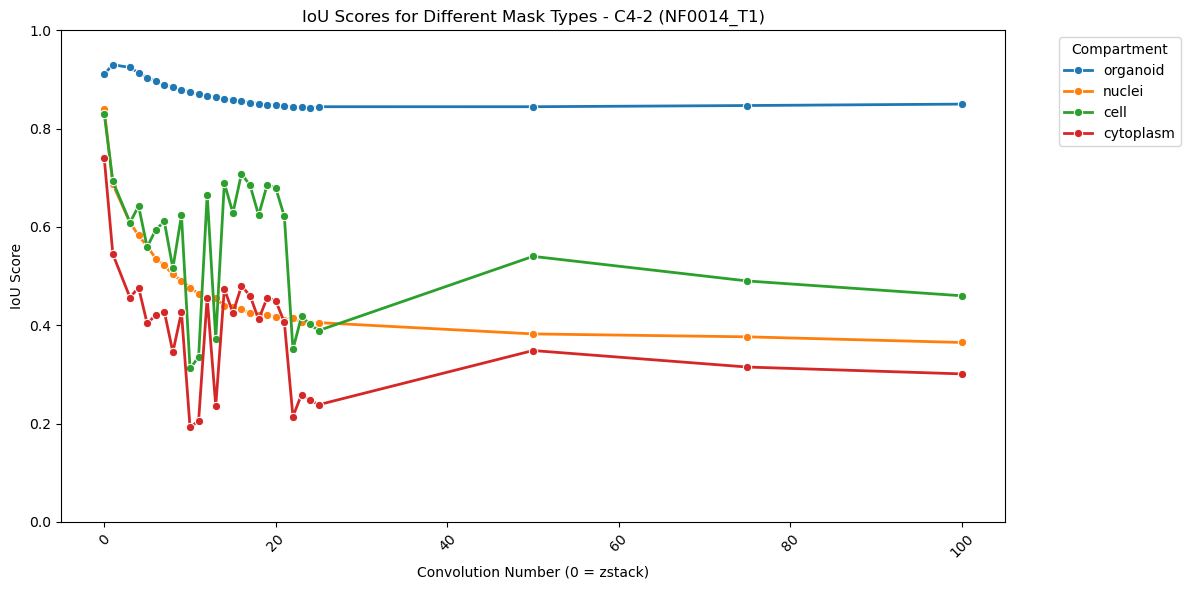

In [9]:
# Create a grouped bar plot with colors by compartment
fig, ax = plt.subplots(figsize=(12, 6))

# Use seaborn for better grouped bar plot
sns.lineplot(
    data=IOU_scores_df,
    x="convolution_number",
    y="IoU Score",
    hue="compartment",
    ax=ax,
    # line width for better visibility
    linewidth=2,
    # add markers for each point
    marker="o",
)

plt.title(f"IoU Scores for Different Mask Types - {well_fov} ({patient})")
plt.xlabel("Convolution Number (0 = zstack)")
plt.ylabel("IoU Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title="Compartment", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()